# Image Classification on iWildCam

This notebook plots the results of various optimization algorithms on the WILDS iWildCam distribution shift benchmark.

In [37]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import pickle
import numpy as np
import pandas as pd

sys.path.append("..")
from src.utils.io import var_to_str, get_path, load_results
from src.utils.data import load_dataset
from src.utils.hyperparams import HYPERPARAM_LR

In [38]:
dataset = "iwildcam"
loss = "multinomial_cross_entropy"
n_class = 60

result_dir = "../results"

In [39]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams["axes.labelsize"] = 34
mpl.rcParams['legend.fontsize'] = 34
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [40]:
l2_reg = 1.0
shift_cost = 1.0

In [41]:
plot_cfgs = [
    {
        "optimizer": "sgd",
        "label": "SGD",
        "color": "black",
        "linestyle": "solid",
        "marker": ".",
    },
    {
        "optimizer": "slsvrg",
        "label": "LSVRG",
        "color": "cadetblue",
        "linestyle": "solid",
        "marker": "o",
    },
    {
        "optimizer": "saddlesaga_v2",
        "label": "SaddleSAGA",
        "color": "goldenrod",
        "linestyle": "solid",
        "marker": "s",
    },
    {
        "optimizer": "lsaga_v3",
        "label": "Prospect (Ours)",
        "color": "tab:red",
        "linestyle": "solid",
        "marker": "^",
    },
]

In [48]:
def get_suboptimality(
    dataset, model_cfg, train_loss, eps=1e-9, out_path="../results/"
):
    init_loss = train_loss[0]
    path = get_path([dataset, var_to_str(model_cfg)], out_path=out_path)
    f = os.path.join(path, "lbfgs_min_loss.p")
    min_loss = pickle.load(open(f, "rb"))
    subopt = (train_loss - min_loss + eps) / (init_loss - min_loss)
    return subopt

def plot_ax(ax, seeds, objective, plot_cfg, epoch_len=20000, n=20000, downsample=4, dataset="iwildcam", markersize=7):
    optimizer = plot_cfg['optimizer']
    lr = HYPERPARAM_LR[optimizer][dataset][objective]
    model_cfg = {
        "objective": objective, 
        "l2_reg": l2_reg, 
        "loss": "multinomial_cross_entropy", 
        "n_class": 60,
        "sm_coef": shift_cost
    }
    for seed in seeds:
        optim_cfg = {
            "optimizer": optimizer,
            "lr": lr,
            "epoch_len": epoch_len,
            "sm_coef": shift_cost,
        }
        results = load_results(dataset, model_cfg, optim_cfg, seed, out_path=result_dir)
        if not (isinstance(results, int)):
            train_loss = torch.tensor(results["metrics"]["train_loss"])
            epochs = torch.arange(len(train_loss))
            subopt = get_suboptimality(
                dataset, model_cfg, train_loss, out_path=result_dir
            )
            if optimizer == "slsvrg":
                x = epochs * (epoch_len + n) / n
            elif optimizer in ["sgd", "srda"]:
                x = epochs * min(64 * epoch_len, n) / n
            else:
                x = epochs * epoch_len / n
            idx = (x <= 64)
            ax.plot(
                x[idx][::downsample], 
                subopt[idx][::downsample], 
                label=plot_cfg['label'], 
                color=plot_cfg['color'],
                marker=plot_cfg['marker'],
                markersize=markersize
            )


In [49]:
def get_iterate(objective, optimizer, seed=0, dataset="iwildcam"):
    model_cfg = {
        "objective": objective,
        "l2_reg": l2_reg,
        "loss": "multinomial_cross_entropy",
        "n_class": 60,
        "sm_coef": shift_cost
    }

    path = get_path([dataset, var_to_str(model_cfg), optimizer], out_path=result_dir)
    f = os.path.join(path, f"best_weights.p")
    return pickle.load(open(f, "rb")).view(-1, n_class).detach()

def get_error(optimizer, objective):
    w = get_iterate(objective, optimizer)
    logits = X_test @ w
    return (y_test != torch.argmax(logits, dim=1)).int()


def get_group_error(optimizer, objective):
    error = get_error(optimizer, objective)

    df = metadata.copy()
    df[f"error"] = error
    # returns (T, G) numpy array where T is the number of iterates and G is the number of groups.
    return df.groupby([0]).mean().to_numpy()[:, 0]

In [50]:
X_train, y_train, X_test, y_test = load_dataset(dataset, data_path="../data/")

print(X_test.shape)
print(y_test.shape)

torch.Size([5000, 157])
torch.Size([5000])


In [51]:
metadata = pd.DataFrame(y_test)
metadata.head()

,0
0,20
1,1
2,21
3,22
4,14


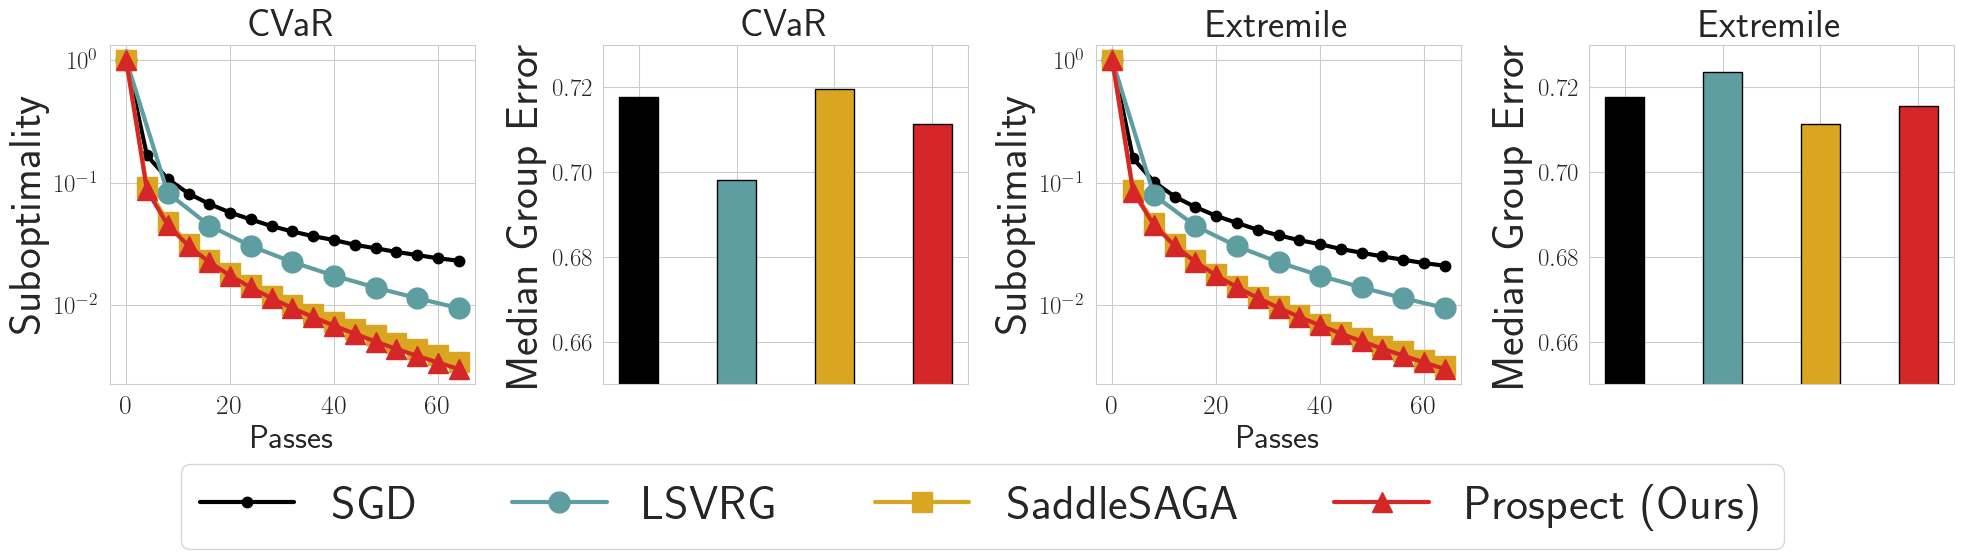

In [52]:
dataset = "iwildcam"
objectives = ["superquantile", "extremile"]

sns.set_style("whitegrid")

# fig, ax = plt.subplots(2, len(objectives), figsize=(5 * len(objectives), 10), sharey="row")
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

obj_names = ["CVaR", "Extremile", "ESRM"]
for j, objective in enumerate(objectives):
    group_means = []
    for plot_cfg in plot_cfgs:
        optimizer = plot_cfg["optimizer"]
        group_error = get_group_error(optimizer, objective)
        # group_means.append(np.mean(group_error))
        group_means.append(np.quantile(group_error, 0.5))
        # xx = np.arange(len(yy))

        markersize = 14
        downsample = 2
        ax[2 * j].set_title(obj_names[j], fontsize=28)
        ax[2 * j + 1].set_title(obj_names[j], fontsize=28)

        if optimizer == "saddlesaga_v2":
            plot_ax(ax[2 * j], [0], objective, plot_cfg, markersize=15)
        else:
            plot_ax(ax[2 * j], [1], objective, plot_cfg, markersize=15)
        ax[2 * j].set_yscale("log")
    ax[2 * j + 1].bar(np.arange(len(plot_cfgs)), group_means, color = [plot_cfg["color"] for plot_cfg in plot_cfgs], width=0.4, edgecolor="k")
    ax[2 * j + 1].set_ylim(0.65, 0.73)
    ax[2 * j + 1].set_xticklabels([])

ax[0].set_xlabel(f"Passes", fontsize=24)
ax[2].set_xlabel(f"Passes", fontsize=24)

ax[0].set_xlabel(f"Passes", fontsize=24)
ax[2].set_xlabel(f"Passes", fontsize=24)

ax[0].set_ylabel(f"Suboptimality", fontsize=32)
ax[1].set_ylabel(f"Median Group Error", fontsize=32)
ax[2].set_ylabel(f"Suboptimality", fontsize=32)
ax[3].set_ylabel(f"Median Group Error", fontsize=32)
plt.tight_layout(pad=2.0)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)
# plt.savefig(f"../figures/iclr/iwildcam_sm_{sm_coef}_reg_{l2_reg}.pdf", bbox_inches="tight")
plt.show()